In this experiment i will try to modify the treshold but for that we will be runing the experiment in a smaller sampler so we can had an oportunity to see how it performs in a smaller dataset.

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

enable_code_paths = True
enable_block = False

if enable_code_paths:
    URL_path = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/clean_dataset.csv"
    URL_path_save = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model"
    URL_helper ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/helper/"
else :
    URL_path = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
    URL_path_save = "/content/drive/MyDrive/turing_college_experiments/14_NLP/model"
    URL_helper = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
import sys
sys.path.append(URL_helper)

from colab_helper import proportion_balance_classes

Mounted at /content/drive


Now we will be installing all the modules that are required

In [2]:
%%capture

!pip install torchinfo optuna deep_translator

We will be exploring the Bert model and see if we could find any good performance

In [3]:
# Main Libraries
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

# PyTorch Libraries
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torchinfo import summary  # Model summary tool for PyTorch

# Transformers Library (for BERT and related utilities)
from transformers import BertTokenizer, BertModel, BertConfig

# Evaluation and Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go

# language translation
from deep_translator import GoogleTranslator

# hyperparameter tunning
import optuna

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# colorama
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)
theme_color

[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [4]:
dataframe = pd.read_csv(URL_path)
# dataframe["not_toxic"] = ((dataframe.iloc[:, 1:] == 0).all(axis=1)).astype(int)
dataframe.head()


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,ExplanationWhy the edits made under my usernam...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""MoreI can't make any real suggestions on impr...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


tensor([0.4357, 0.0435, 0.2409, 0.0137, 0.2262, 0.0400])
total samples 144790


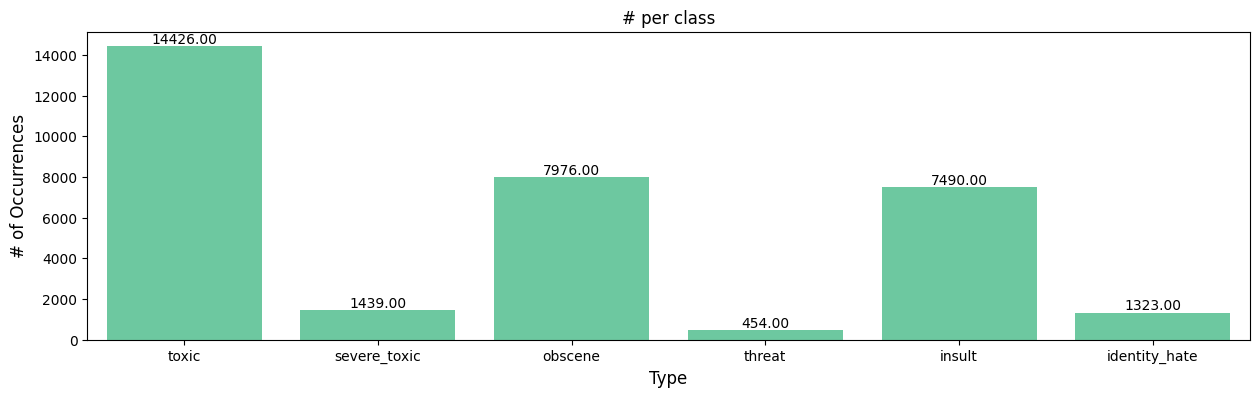

In [5]:
target_y =dataframe.iloc[:,1:].sum()

weights_list = target_y.tolist()
weights = torch.tensor(weights_list, dtype=torch.float32)
normalized_weights = weights / weights.sum()
print(normalized_weights)

print(f"total samples {dataframe.shape[0]}")
proportion_balance_classes(target_y.index, target_y.values)

# Oversampling
Now we will oversample the dataset by duplicating instances in categories with fewer examples. This will help balance the distribution and ensure that each category is more equally represented.

In [6]:
def translation_again(column_translate, start_lang='en', mid_lang='de'):
    """Translates text to a middle language and back to the source language."""
    list_text_traduction = []

    for text in column_translate:
        try:
            # Translate to intermediate language
            text_traduction = GoogleTranslator(source=start_lang, target=mid_lang).translate(text)
            # Translate back to the original language
            text_traduction = GoogleTranslator(source=mid_lang, target=start_lang).translate(text)
            list_text_traduction.append(text_traduction)
        except Exception as e:
            print(f"Error in translation: {e}")
            # Append original text if an error occurs
            list_text_traduction.append(text)

    # Create a DataFrame with original and backtranslated text
    df = pd.DataFrame({
        'original_text': column_translate,
        'backtranslated_text': list_text_traduction
    })

    return df


We will filtered the values where we had less cases

In [7]:
dataframe_oversampling_1 = dataframe[dataframe["severe_toxic"] == 1]
dataframe_oversampling_2 = dataframe[dataframe["threat"] == 1]
dataframe_oversampling_3 = dataframe[dataframe["identity_hate"] == 1]

In [8]:
if enable_block:
    sample = translation_again(column_translate = dataframe_oversampling_2["comment_text"], start_lang='en', mid_lang='de')
    sample.to_csv(f'{URL_helper}sample_data_example.csv', index=False)
else:
    sample_data = pd.read_csv(f'{URL_helper}sample_data_example.csv')

In [9]:
range_values = np.arange(50,60)

for value in range_values:
    for i in sample_data.iloc[value]:
        print(i)

Hey, you fascist swine, you're gonna get raped in the ass. Nice job being Jimbo's bitch, you pathetic piece of shit.
Hey, you fascist swine, you're gonna get raped in the ass. Nice job being Jimbo's bitch, you pathetic piece of shit.
That's funny. You was personally offended? So the bad things writer new you, your name etc, right? And one get offended by a comment, or epithets on a website, then that same person must grow up spiritually for some more 5 centuries at least.And if one get more offended by the previous comment, then that same person must kill him/hersef.Take care!
That's funny. You were personally offended? So the bad things writer new you, your name etc, right? And one get more offended by a comment, or epithets on a website, then that same person must grow up spiritually for some more 5 centuries at least.And if one get more offended by the previous comment, then that same person must kill him/hersef .Take care!
You are the troll, anti-Semite. All anti-Semites should die

After reviewing the transformation, we noticed that there were no changes in the probabilities in cases where the words were altered, only some duplicates appeared. Therefore, we will skip translating the entire text in these cases and leave the original text unchanged. We will not be adding more samples using this technique.

### weights
In this case we will try to amplify the weigts discretionaly hoping that we could get a better result for those clases where we are not getting any class!

In [10]:
amplication_value = 2
normalized_weights_modify = normalized_weights
normalized_weights_modify[1] = normalized_weights[1] * amplication_value
normalized_weights_modify[3] = normalized_weights[3] * amplication_value
normalized_weights_modify[5] = normalized_weights[5] * amplication_value
normalized_weights_modify

tensor([0.4357, 0.0869, 0.2409, 0.0274, 0.2262, 0.0799])

Now that we had a smaller dataset with all the data around the same balance, we will try to

# Dataset Parameters and model selection
- **MAX_LEN**: Maximum length of the tokenized sequences
- **TRAIN_BATCH_SIZE**: Batch size for the training set
- **VALID_BATCH_SIZE**: Batch size for the validation set


Then we select the BERT model

In [11]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
SAMPLE_PERCENTAGE = 0.30


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
class CustomDataset(Dataset):
    """Tokenize the dataset for using it in the model"""
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,                     # The text to encode
            None,                              # Optional second input (e.g., for sentence pairs)
            add_special_tokens=True,           # Add special tokens ([CLS], [SEP])
            max_length=self.max_len,           # Truncate to max_len if necessary
            padding='max_length',              # Pad the sequence to max_len
            truncation=True,                   # Truncate if longer than max_len
            return_token_type_ids=True        # Return token type IDs
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        values_return = {
                        'ids': torch.tensor(ids, dtype=torch.int64),
                        'mask': torch.tensor(mask, dtype=torch.int64),
                        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.int64),
                        'targets': torch.tensor(self.targets[index], dtype=torch.float)
                         }

        return values_return

# split and dataloader

We divided the dataset into 90% for training and 10% for validation in order to assess potential improvements in performance.


In [13]:
# sample sisze

dataframe_clean=dataframe.sample(frac=SAMPLE_PERCENTAGE,random_state=42)

# split
train_size = 0.8
train_dataset=dataframe_clean.sample(frac=train_size,random_state=42)
test_dataset=dataframe_clean.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(dataframe_clean.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))


FULL Dataset: (43437, 7)
TRAIN Dataset: (34750, 7)
TEST Dataset: (8687, 7)


<ipython-input-14-98c5f67832ab>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for better visibility
<ipython-input-14-98c5f67832ab>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for better visibility
<ipython-input-14-98c5f67832ab>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for better visibility


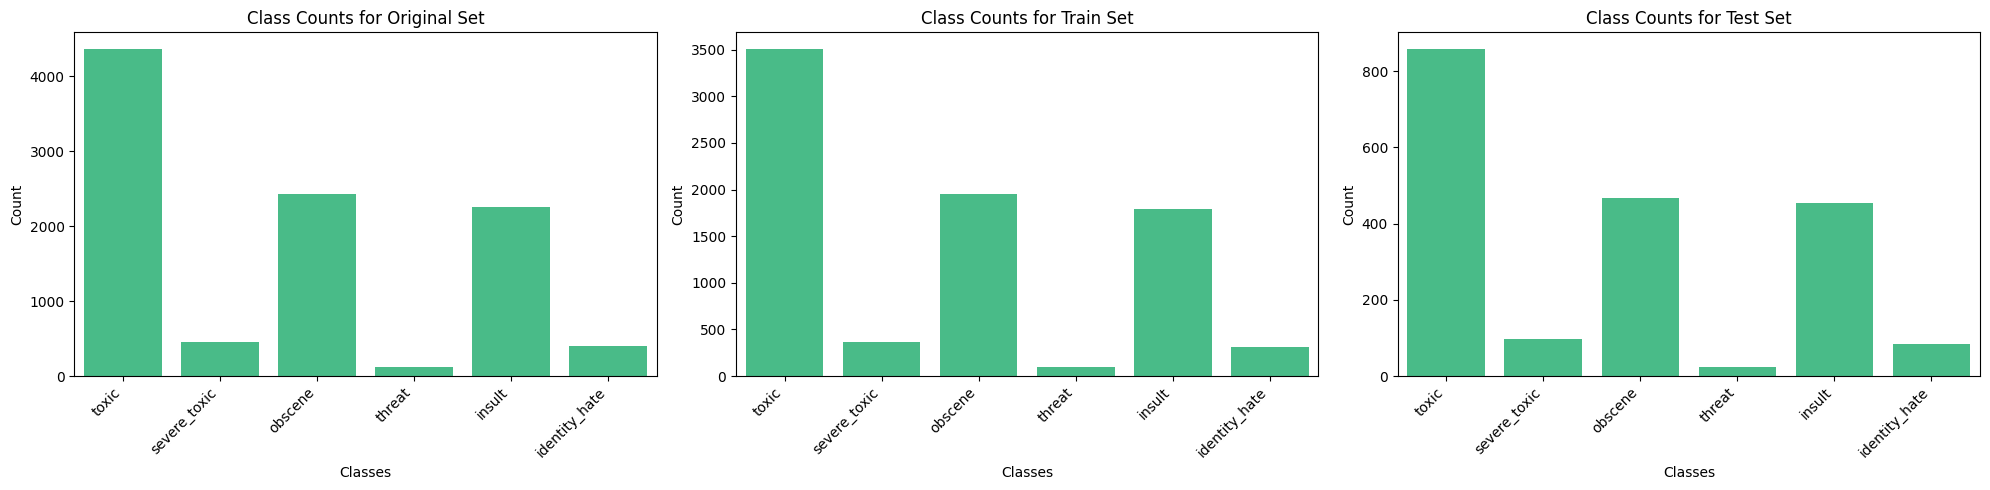

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate class counts for each dataset
# Summing over each column to count occurrences of each class in each dataset
all_counts_dfs = pd.DataFrame({
    'Original Set': dataframe_clean[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(),
    'Train Set': train_dataset[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(),
    'Test Set': test_dataset[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
})

# Plot setup
fig, axes = plt.subplots(nrows=1, ncols=len(all_counts_dfs.columns), figsize=(20, 5))

# Iterate over the columns to create a bar chart for each dataset
for ax, column in zip(axes, all_counts_dfs.columns):
    sns.barplot(x=all_counts_dfs.index, y=all_counts_dfs[column], ax=ax)
    ax.set_title(f'Class Counts for {column}')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for better visibility

# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
# join the dataset
train_dataset['list'] = train_dataset[train_dataset.columns[1:]].values.tolist()
train_dataset = train_dataset[['comment_text', 'list']].copy()

test_dataset['list'] = test_dataset[test_dataset.columns[1:]].values.tolist()
test_dataset = test_dataset[['comment_text', 'list']].copy()

# transforming the dataset
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

# dataloader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

----------

# Fine tune the model

In [16]:
class BertClass(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l3 = torch.nn.Dropout(dropout_rate)
        # because we are trying to predict 6 classes
        self.l4 = torch.nn.Linear(768, 6)

        # freeze the layers
        for param in self.l1.parameters():
            param.requires_grad = False
        for param in self.l1.encoder.layer[-1].parameters():
            param.requires_grad = True

        # name of the layers
        self.layer_names = {
            'bert_model': self.l1,
            'dropout': self.l3,
            'output_layer': self.l4,
        }

    def forward(self, ids, mask, token_type_ids):

        assert isinstance(ids, torch.Tensor), f"Expected tensor, got {type(ids)} for ids"
        assert isinstance(mask, torch.Tensor), f"Expected tensor, got {type(mask)} for mask"
        assert isinstance(token_type_ids, torch.Tensor), f"Expected tensor, got {type(token_type_ids)} for token_type_ids"

        output_1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output_1 = output_1[1]
        output_3 = self.l3(output_1)
        output = self.l4(output_3)

        return output

model_bert = BertClass()
model_bert.to(device)

summary(model_bert)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Layer (type:depth-idx)                                       Param #
BertClass                                                    --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   (23,440,896)
│    │    └─Embedding: 3-2                                   (393,216)
│    │    └─Embedding: 3-3                                   (1,536)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                           

We will be looking now the freezing layers to undestand which once the model need to be trainable

In [17]:
def get_freeze_status_df(model):
    """ Returns a DataFrame indicating whether each layer is trainable or frozen. """
    freeze_status = []
    for name, param in model.named_parameters():
        freeze_status.append({
            'Layer Name': name,
            'Trainable': param.requires_grad
        })

    return pd.DataFrame(freeze_status)

# Call the function
freeze_status_df = get_freeze_status_df(model_bert)
freeze_status_df[freeze_status_df["Trainable"] == True ]

,Layer Name,Trainable
181,l1.encoder.layer.11.attention.self.query.weight,True
182,l1.encoder.layer.11.attention.self.query.bias,True
183,l1.encoder.layer.11.attention.self.key.weight,True
184,l1.encoder.layer.11.attention.self.key.bias,True
185,l1.encoder.layer.11.attention.self.value.weight,True
186,l1.encoder.layer.11.attention.self.value.bias,True
187,l1.encoder.layer.11.attention.output.dense.weight,True
188,l1.encoder.layer.11.attention.output.dense.bias,True
189,l1.encoder.layer.11.attention.output.LayerNorm...,True
190,l1.encoder.layer.11.attention.output.LayerNorm...,True


# Train and test the model
We will run multiple examples using hyperparameters just to had an idea that what would be the best parameters for this models

In [18]:
# Metric calculation functions
def calculate_accuracy(outputs, targets, threshold=0.5):
    if isinstance(outputs, np.ndarray):
        outputs = torch.tensor(outputs)
    preds = torch.sigmoid(outputs)
    preds = (preds >= threshold).float()
    correct_preds = (preds == targets).float()
    accuracy_per_sample = correct_preds.mean(dim=1)
    return accuracy_per_sample.mean().item()

def calculate_recall(outputs, targets, threshold=0.5):
    if isinstance(outputs, np.ndarray):
        outputs = torch.tensor(outputs)
    preds = torch.sigmoid(outputs)
    preds = (preds >= threshold).float()
    true_positives = (preds * targets).sum(dim=0)
    false_negatives = ((1 - preds) * targets).sum(dim=0)
    recall_per_label = true_positives / (true_positives + false_negatives + 1e-10)
    return recall_per_label.mean().item()

"""
--------------------------------------
Training
--------------------------------------
"""
def train(epoch, model, dataset_loader, device, threshold, optimizer, loss_fn):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_accuracy = 0.0
    running_recall = 0.0
    total_samples = 0

    for _, data in tqdm(enumerate(dataset_loader, 0), total=len(dataset_loader)):
        ids = data['ids'].to(device, dtype=torch.int32)
        mask = data['mask'].to(device, dtype=torch.int32)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.int64)
        targets = data['targets'].to(device, dtype=torch.float32)  # BCEWithLogitsLoss requires float targets

        # Forward pass
        outputs = model(ids, mask, token_type_ids)

        # Compute loss and backpropagate
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        # Update running loss and metrics
        running_loss += loss.item() * ids.size(0)  # Scale by batch size
        running_accuracy += calculate_accuracy(outputs, targets, threshold) * ids.size(0)
        running_recall += calculate_recall(outputs, targets, threshold) * ids.size(0)
        total_samples += ids.size(0)

    # Compute epoch-level metrics
    epoch_loss = running_loss / total_samples
    epoch_accuracy = running_accuracy / total_samples
    epoch_recall = running_recall / total_samples

    print(f"Epoch {epoch} - Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}, Training Recall: {epoch_recall:.4f}")
    return model, epoch_loss, epoch_accuracy, epoch_recall


"""
--------------------------------------
Validation
--------------------------------------
"""
loss_values = []
accuracy_values = []
recall_values = []  # Initialize a list to store recall values

def validation(epoch, model, dataloader, device, loss_fn, threshold_target=0.5):
    model.eval()  # Set model to evaluation mode
    fin_targets = []
    fin_outputs = []
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for _, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
            ids = data['ids'].to(device, dtype=torch.int32  )
            mask = data['mask'].to(device, dtype=torch.int32  )
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.int64)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)  # Calculate loss
            total_loss += loss.item() * ids.size(0)
            total_samples += ids.size(0)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    # Calculate average loss over the entire validation set
    avg_loss = total_loss / total_samples
    fin_outputs = (np.array(fin_outputs) > threshold_target).astype(int)
    fin_targets = np.array(fin_targets)

    accuracy = calculate_accuracy(fin_outputs, fin_targets, threshold_target)
    recall = calculate_recall(fin_outputs, fin_targets, threshold_target)

    loss_values.append(avg_loss)
    accuracy_values.append(accuracy)
    recall_values.append(recall)  # Append recall to the list

    print(f"Epoch {epoch} - Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}, Validation Recall: {recall:.4f}")
    return fin_outputs, fin_targets, loss_values, accuracy_values, recall_values

#

In [19]:
EPOCHS = 1
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=False)
model_name_to_save = "007_model_bert_threshold"

def objective(trial):
    # Suggest hyperparameters for tuning
    learning_rate_bert = trial.suggest_loguniform('learning_rate_bert', 1e-6, 1e-3)
    learning_rate_fc = trial.suggest_loguniform('learning_rate_fc', 1e-5, 1e-2)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    threshold = trial.suggest_uniform('threshold', 0.3, 0.7)

    # Initialize model with suggested hyperparameters
    model_bert = BertClass(dropout_rate=dropout_rate)
    model_bert.to(device)

    # Loss function with pos_weight if tuning it
    # loss_fun_object = torch.nn.BCEWithLogitsLoss(pos_weight=normalized_weights)
    # def loss_fn(outputs, targets):
    #     return loss_fun_object(outputs, targets)
    loss_fun_object = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(normalized_weights).to(device))


    # Optimizer with parameter groups
    param_groups = [
        {'params': model_bert.l1.parameters(), 'lr': learning_rate_bert * 0.1},  # Smaller learning rate for BERT layers
        {'params': model_bert.l3.parameters(), 'lr': learning_rate_fc}  # Larger learning rate for custom layers
    ]

    optimizer = torch.optim.AdamW(param_groups, weight_decay=weight_decay)

    # Track metrics for each epoch
    train_loss_values = []
    train_accuracy_values = []
    train_recall_values = []

    valid_loss_values = []
    valid_accuracy_values = []
    valid_recall_values = []

    # Training and validation loops
    for epoch in range(EPOCHS):
        # Run training and validation for each epoch
        model_bert, train_loss, train_accuracy, train_recall = train(
            epoch, model_bert, training_loader, device, threshold, optimizer, loss_fn=loss_fun_object
        )
        _, _, valid_loss, valid_accuracy, valid_recall = validation(
            epoch, model_bert, testing_loader, device, loss_fn=loss_fun_object, threshold_target=threshold
        )

        # Store metrics
        train_loss_values.append(train_loss)
        train_accuracy_values.append(train_accuracy)
        train_recall_values.append(train_recall)

        valid_loss_values.append(valid_loss[-1])  # Last value in validation loss list
        valid_accuracy_values.append(valid_accuracy[-1])
        valid_recall_values.append(valid_recall[-1])

        print(f"Epoch {epoch}:")
        print(f"  Train Loss: {train_loss_values[-1]:.4f}")
        print(f"  Train Accuracy: {train_accuracy_values[-1]:.4f}")
        print(f"  Train Recall: {train_recall_values[-1]:.4f}")
        print(f"  Valid Loss: {valid_loss_values[-1]:.4f}")
        print(f"  Valid Accuracy: {valid_accuracy_values[-1]:.4f}")
        print(f"  Valid Recall: {valid_recall_values[-1]:.4f}")
        print(f"================================")

    # Return the validation loss for the current trial as well as all metrics for tracking
    return {
        "final_valid_loss": valid_loss_values[-1],
        "train_loss_values": train_loss_values,
        "train_accuracy_values": train_accuracy_values,
        "train_recall_values": train_recall_values,
        "valid_loss_values": valid_loss_values,
        "valid_accuracy_values": valid_accuracy_values,
        "valid_recall_values": valid_recall_values
    }


In [20]:
import optuna
from google.colab import files

# Define storage and study configuration
storage_name = "sqlite:///optuna_study.db"
study = optuna.create_study(direction='minimize', study_name="002_Bert", storage=storage_name, load_if_exists=True)

# Run optimization
study.optimize(objective, n_trials=22)

[I 2024-11-07 21:19:55,612] A new study created in RDB with name: 002_Bert
<ipython-input-19-a5eeba606b28>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_bert = trial.suggest_loguniform('learning_rate_bert', 1e-6, 1e-3)
<ipython-input-19-a5eeba606b28>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_fc = trial.suggest_loguniform('learning_rate_fc', 1e-5, 1e-2)
<ipython-input-19-a5eeba606b28>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5

Epoch 0 - Training Loss: 0.3732, Training Accuracy: 0.8635, Training Recall: 0.0346


100%|██████████| 2172/2172 [00:43<00:00, 50.18it/s]
[W 2024-11-07 21:23:47,064] Trial 0 failed with parameters: {'learning_rate_bert': 1.368591827216284e-05, 'learning_rate_fc': 0.00044674614891431716, 'dropout_rate': 0.4581763179367563, 'weight_decay': 9.03361385526757e-05, 'threshold': 0.46880307383381503} because of the following error: The value {'final_valid_loss': 0.24081214985728636, 'train_loss_values': [0.3731768541387517], 'train_accuracy_values': [0.8634580481892867], 'train_recall_values': [0.03457841819653408], 'valid_loss_values': [0.24081214985728636], 'valid_accuracy_values': [0.03806454315781593], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 21:23:47,065] Trial 0 failed with value {'final_valid_loss': 0.24081214985728636, 'train_loss_values': [0.3731768541387517], 'train_accuracy_values': [0.8634580481892867], 'train_recall_values': [0.03457841819653408], 'valid_loss_values': [0.24081214985728636], 'valid_accuracy_values': [0.0

Epoch 0 - Validation Loss: 0.2408, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.3732
  Train Accuracy: 0.8635
  Train Recall: 0.0346
  Valid Loss: 0.2408
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


<ipython-input-19-a5eeba606b28>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fun_object = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(normalized_weights).to(device))
100%|██████████| 4344/4344 [03:03<00:00, 23.61it/s]


Epoch 0 - Training Loss: 0.6640, Training Accuracy: 0.1660, Training Recall: 0.2355


100%|██████████| 2172/2172 [00:43<00:00, 50.44it/s]
[W 2024-11-07 21:27:34,559] Trial 1 failed with parameters: {'learning_rate_bert': 1.1370273517029883e-06, 'learning_rate_fc': 0.00043861031643434295, 'dropout_rate': 0.16922278655658513, 'weight_decay': 0.0003482057134215395, 'threshold': 0.3799387008084991} because of the following error: The value {'final_valid_loss': 0.6101437264486685, 'train_loss_values': [0.6640023073086636], 'train_accuracy_values': [0.1660479665947475], 'train_recall_values': [0.23552038838365952], 'valid_loss_values': [0.6101437264486685], 'valid_accuracy_values': [0.038064539432525635], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 21:27:34,559] Trial 1 failed with value {'final_valid_loss': 0.6101437264486685, 'train_loss_values': [0.6640023073086636], 'train_accuracy_values': [0.1660479665947475], 'train_recall_values': [0.23552038838365952], 'valid_loss_values': [0.6101437264486685], 'valid_accuracy_values': [0.03

Epoch 0 - Validation Loss: 0.6101, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.6640
  Train Accuracy: 0.1660
  Train Recall: 0.2355
  Valid Loss: 0.6101
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


100%|██████████| 4344/4344 [03:03<00:00, 23.63it/s]


Epoch 0 - Training Loss: 0.2014, Training Accuracy: 0.9660, Training Recall: 0.0273


100%|██████████| 2172/2172 [00:43<00:00, 50.29it/s]
[W 2024-11-07 21:31:22,031] Trial 2 failed with parameters: {'learning_rate_bert': 0.00042719756156351697, 'learning_rate_fc': 8.553175760662338e-05, 'dropout_rate': 0.13092038364948644, 'weight_decay': 1.461726370351581e-06, 'threshold': 0.6834240247833258} because of the following error: The value {'final_valid_loss': 0.15793766484095062, 'train_loss_values': [0.20139552333972438], 'train_accuracy_values': [0.9660144010790818], 'train_recall_values': [0.027336211896628784], 'valid_loss_values': [0.15793766484095062], 'valid_accuracy_values': [0.9682474732398987], 'valid_recall_values': [0.06616926708761202]} could not be cast to float.
[W 2024-11-07 21:31:22,032] Trial 2 failed with value {'final_valid_loss': 0.15793766484095062, 'train_loss_values': [0.20139552333972438], 'train_accuracy_values': [0.9660144010790818], 'train_recall_values': [0.027336211896628784], 'valid_loss_values': [0.15793766484095062], 'valid_accuracy_values':

Epoch 0 - Validation Loss: 0.1579, Validation Accuracy: 0.9682, Validation Recall: 0.0662
Epoch 0:
  Train Loss: 0.2014
  Train Accuracy: 0.9660
  Train Recall: 0.0273
  Valid Loss: 0.1579
  Valid Accuracy: 0.9682
  Valid Recall: 0.0662


100%|██████████| 4344/4344 [03:03<00:00, 23.63it/s]


Epoch 0 - Training Loss: 0.2352, Training Accuracy: 0.9637, Training Recall: 0.0169


100%|██████████| 2172/2172 [00:43<00:00, 50.09it/s]
[W 2024-11-07 21:35:09,689] Trial 3 failed with parameters: {'learning_rate_bert': 0.00013880974517012197, 'learning_rate_fc': 0.0004629639553407343, 'dropout_rate': 0.30788540578171997, 'weight_decay': 8.60834234411356e-06, 'threshold': 0.622822425635994} because of the following error: The value {'final_valid_loss': 0.1942763576693374, 'train_loss_values': [0.2351669002668463], 'train_accuracy_values': [0.9636786688660546], 'train_recall_values': [0.01687546012212904], 'valid_loss_values': [0.1942763576693374], 'valid_accuracy_values': [0.970051109790802], 'valid_recall_values': [0.10097435807948736]} could not be cast to float.
[W 2024-11-07 21:35:09,690] Trial 3 failed with value {'final_valid_loss': 0.1942763576693374, 'train_loss_values': [0.2351669002668463], 'train_accuracy_values': [0.9636786688660546], 'train_recall_values': [0.01687546012212904], 'valid_loss_values': [0.1942763576693374], 'valid_accuracy_values': [0.9700511

Epoch 0 - Validation Loss: 0.1943, Validation Accuracy: 0.9701, Validation Recall: 0.1010
Epoch 0:
  Train Loss: 0.2352
  Train Accuracy: 0.9637
  Train Recall: 0.0169
  Valid Loss: 0.1943
  Valid Accuracy: 0.9701
  Valid Recall: 0.1010


100%|██████████| 4344/4344 [03:04<00:00, 23.59it/s]


Epoch 0 - Training Loss: 0.2672, Training Accuracy: 0.9614, Training Recall: 0.0001


100%|██████████| 2172/2172 [00:43<00:00, 50.37it/s]
[W 2024-11-07 21:38:57,397] Trial 4 failed with parameters: {'learning_rate_bert': 6.899997734645598e-05, 'learning_rate_fc': 0.0013513126057845446, 'dropout_rate': 0.23714137733014728, 'weight_decay': 0.0006456327310118588, 'threshold': 0.6947682429643349} because of the following error: The value {'final_valid_loss': 0.21956395508368326, 'train_loss_values': [0.26723113014372135], 'train_accuracy_values': [0.961414879428397], 'train_recall_values': [0.00013429256994947254], 'valid_loss_values': [0.21956395508368326], 'valid_accuracy_values': [0.9626645445823669], 'valid_recall_values': [0.007372914241365071]} could not be cast to float.
[W 2024-11-07 21:38:57,398] Trial 4 failed with value {'final_valid_loss': 0.21956395508368326, 'train_loss_values': [0.26723113014372135], 'train_accuracy_values': [0.961414879428397], 'train_recall_values': [0.00013429256994947254], 'valid_loss_values': [0.21956395508368326], 'valid_accuracy_values

Epoch 0 - Validation Loss: 0.2196, Validation Accuracy: 0.9627, Validation Recall: 0.0074
Epoch 0:
  Train Loss: 0.2672
  Train Accuracy: 0.9614
  Train Recall: 0.0001
  Valid Loss: 0.2196
  Valid Accuracy: 0.9627
  Valid Recall: 0.0074


100%|██████████| 4344/4344 [03:04<00:00, 23.60it/s]


Epoch 0 - Training Loss: 0.2356, Training Accuracy: 0.9568, Training Recall: 0.0481


100%|██████████| 2172/2172 [00:43<00:00, 49.99it/s]
[W 2024-11-07 21:42:45,312] Trial 5 failed with parameters: {'learning_rate_bert': 0.00013257135156302503, 'learning_rate_fc': 0.0005538127623941346, 'dropout_rate': 0.3497615715099893, 'weight_decay': 5.271913364933068e-06, 'threshold': 0.4189537454727997} because of the following error: The value {'final_valid_loss': 0.19580280687477725, 'train_loss_values': [0.23562408226256748], 'train_accuracy_values': [0.9568441369756521], 'train_recall_values': [0.048054997210022356], 'valid_loss_values': [0.19580280687477725], 'valid_accuracy_values': [0.038064539432525635], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 21:42:45,312] Trial 5 failed with value {'final_valid_loss': 0.19580280687477725, 'train_loss_values': [0.23562408226256748], 'train_accuracy_values': [0.9568441369756521], 'train_recall_values': [0.048054997210022356], 'valid_loss_values': [0.19580280687477725], 'valid_accuracy_values':

Epoch 0 - Validation Loss: 0.1958, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.2356
  Train Accuracy: 0.9568
  Train Recall: 0.0481
  Valid Loss: 0.1958
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


100%|██████████| 4344/4344 [03:04<00:00, 23.59it/s]


Epoch 0 - Training Loss: 0.3048, Training Accuracy: 0.9348, Training Recall: 0.0048


100%|██████████| 2172/2172 [00:43<00:00, 50.22it/s]
[W 2024-11-07 21:46:33,148] Trial 6 failed with parameters: {'learning_rate_bert': 3.7569408864765265e-05, 'learning_rate_fc': 0.0007054554243655909, 'dropout_rate': 0.21744043322648135, 'weight_decay': 9.848925281940282e-05, 'threshold': 0.4982808369731516} because of the following error: The value {'final_valid_loss': 0.23635911821797567, 'train_loss_values': [0.3048347801561836], 'train_accuracy_values': [0.9348393406490628], 'train_recall_values': [0.004780175998056535], 'valid_loss_values': [0.23635911821797567], 'valid_accuracy_values': [0.03806454315781593], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 21:46:33,150] Trial 6 failed with value {'final_valid_loss': 0.23635911821797567, 'train_loss_values': [0.3048347801561836], 'train_accuracy_values': [0.9348393406490628], 'train_recall_values': [0.004780175998056535], 'valid_loss_values': [0.23635911821797567], 'valid_accuracy_values': [

Epoch 0 - Validation Loss: 0.2364, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.3048
  Train Accuracy: 0.9348
  Train Recall: 0.0048
  Valid Loss: 0.2364
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


100%|██████████| 4344/4344 [03:04<00:00, 23.60it/s]


Epoch 0 - Training Loss: 0.2611, Training Accuracy: 0.9144, Training Recall: 0.0329


100%|██████████| 2172/2172 [00:43<00:00, 50.05it/s]
[W 2024-11-07 21:50:21,094] Trial 7 failed with parameters: {'learning_rate_bert': 6.376505482574892e-05, 'learning_rate_fc': 0.0020653424458932485, 'dropout_rate': 0.20320501599304985, 'weight_decay': 0.0004801071849044476, 'threshold': 0.35675577689626314} because of the following error: The value {'final_valid_loss': 0.20931412817536585, 'train_loss_values': [0.2611202878883417], 'train_accuracy_values': [0.9143980936296552], 'train_recall_values': [0.0328521191494928], 'valid_loss_values': [0.20931412817536585], 'valid_accuracy_values': [0.03806454315781593], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 21:50:21,095] Trial 7 failed with value {'final_valid_loss': 0.20931412817536585, 'train_loss_values': [0.2611202878883417], 'train_accuracy_values': [0.9143980936296552], 'train_recall_values': [0.0328521191494928], 'valid_loss_values': [0.20931412817536585], 'valid_accuracy_values': [0.03

Epoch 0 - Validation Loss: 0.2093, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.2611
  Train Accuracy: 0.9144
  Train Recall: 0.0329
  Valid Loss: 0.2093
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


100%|██████████| 4344/4344 [03:03<00:00, 23.62it/s]


Epoch 0 - Training Loss: 0.2368, Training Accuracy: 0.9480, Training Recall: 0.0577


100%|██████████| 2172/2172 [00:43<00:00, 50.20it/s]
[W 2024-11-07 21:54:08,702] Trial 8 failed with parameters: {'learning_rate_bert': 0.00014783043982117975, 'learning_rate_fc': 0.0007495961419638534, 'dropout_rate': 0.3573028245622011, 'weight_decay': 1.1631427697964617e-05, 'threshold': 0.35320378542417047} because of the following error: The value {'final_valid_loss': 0.1955158804274544, 'train_loss_values': [0.23675129661971717], 'train_accuracy_values': [0.9480335853091246], 'train_recall_values': [0.05765499731791105], 'valid_loss_values': [0.1955158804274544], 'valid_accuracy_values': [0.03806454315781593], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 21:54:08,703] Trial 8 failed with value {'final_valid_loss': 0.1955158804274544, 'train_loss_values': [0.23675129661971717], 'train_accuracy_values': [0.9480335853091246], 'train_recall_values': [0.05765499731791105], 'valid_loss_values': [0.1955158804274544], 'valid_accuracy_values': [0.0

Epoch 0 - Validation Loss: 0.1955, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.2368
  Train Accuracy: 0.9480
  Train Recall: 0.0577
  Valid Loss: 0.1955
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


100%|██████████| 4344/4344 [03:04<00:00, 23.59it/s]


Epoch 0 - Training Loss: 0.1907, Training Accuracy: 0.9666, Training Recall: 0.0376


100%|██████████| 2172/2172 [00:43<00:00, 50.31it/s]
[W 2024-11-07 21:57:56,453] Trial 9 failed with parameters: {'learning_rate_bert': 0.00028869535265206976, 'learning_rate_fc': 0.0005535633105173191, 'dropout_rate': 0.37113839697837214, 'weight_decay': 0.0001314331915377282, 'threshold': 0.5368040962622858} because of the following error: The value {'final_valid_loss': 0.1518414789902762, 'train_loss_values': [0.1907025262709144], 'train_accuracy_values': [0.966604328471122], 'train_recall_values': [0.037575700519753875], 'valid_loss_values': [0.1518414789902762], 'valid_accuracy_values': [0.9731974005699158], 'valid_recall_values': [0.14083204264293428]} could not be cast to float.
[W 2024-11-07 21:57:56,454] Trial 9 failed with value {'final_valid_loss': 0.1518414789902762, 'train_loss_values': [0.1907025262709144], 'train_accuracy_values': [0.966604328471122], 'train_recall_values': [0.037575700519753875], 'valid_loss_values': [0.1518414789902762], 'valid_accuracy_values': [0.9731

Epoch 0 - Validation Loss: 0.1518, Validation Accuracy: 0.9732, Validation Recall: 0.1408
Epoch 0:
  Train Loss: 0.1907
  Train Accuracy: 0.9666
  Train Recall: 0.0376
  Valid Loss: 0.1518
  Valid Accuracy: 0.9732
  Valid Recall: 0.1408


100%|██████████| 4344/4344 [03:04<00:00, 23.60it/s]


Epoch 0 - Training Loss: 0.2973, Training Accuracy: 0.9408, Training Recall: 0.0036


100%|██████████| 2172/2172 [00:43<00:00, 50.19it/s]
[W 2024-11-07 22:01:44,246] Trial 10 failed with parameters: {'learning_rate_bert': 3.770340331720375e-05, 'learning_rate_fc': 0.004650445574220883, 'dropout_rate': 0.36106896825767687, 'weight_decay': 2.3333916099584185e-06, 'threshold': 0.5170716958414547} because of the following error: The value {'final_valid_loss': 0.22982955405548003, 'train_loss_values': [0.29725305899098625], 'train_accuracy_values': [0.9407530099333619], 'train_recall_values': [0.0035779377582261887], 'valid_loss_values': [0.22982955405548003], 'valid_accuracy_values': [0.9619355201721191], 'valid_recall_values': [0.0]} could not be cast to float.
[W 2024-11-07 22:01:44,247] Trial 10 failed with value {'final_valid_loss': 0.22982955405548003, 'train_loss_values': [0.29725305899098625], 'train_accuracy_values': [0.9407530099333619], 'train_recall_values': [0.0035779377582261887], 'valid_loss_values': [0.22982955405548003], 'valid_accuracy_values': [0.961935520

Epoch 0 - Validation Loss: 0.2298, Validation Accuracy: 0.9619, Validation Recall: 0.0000
Epoch 0:
  Train Loss: 0.2973
  Train Accuracy: 0.9408
  Train Recall: 0.0036
  Valid Loss: 0.2298
  Valid Accuracy: 0.9619
  Valid Recall: 0.0000


100%|██████████| 4344/4344 [03:03<00:00, 23.61it/s]


Epoch 0 - Training Loss: 0.3120, Training Accuracy: 0.7834, Training Recall: 0.0613


100%|██████████| 2172/2172 [00:43<00:00, 50.21it/s]
[W 2024-11-07 22:05:31,912] Trial 11 failed with parameters: {'learning_rate_bert': 2.4411395403828288e-05, 'learning_rate_fc': 7.346143803603913e-05, 'dropout_rate': 0.3045810836442714, 'weight_decay': 8.161674071661016e-05, 'threshold': 0.3100426836627202} because of the following error: The value {'final_valid_loss': 0.22142487307906467, 'train_loss_values': [0.31196872048326535], 'train_accuracy_values': [0.7834484554044634], 'train_recall_values': [0.061270664926055526], 'valid_loss_values': [0.22142487307906467], 'valid_accuracy_values': [0.03806454315781593], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 22:05:31,913] Trial 11 failed with value {'final_valid_loss': 0.22142487307906467, 'train_loss_values': [0.31196872048326535], 'train_accuracy_values': [0.7834484554044634], 'train_recall_values': [0.061270664926055526], 'valid_loss_values': [0.22142487307906467], 'valid_accuracy_values'

Epoch 0 - Validation Loss: 0.2214, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.3120
  Train Accuracy: 0.7834
  Train Recall: 0.0613
  Valid Loss: 0.2214
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


100%|██████████| 4344/4344 [03:03<00:00, 23.62it/s]


Epoch 0 - Training Loss: 0.4233, Training Accuracy: 0.9608, Training Recall: 0.0000


100%|██████████| 2172/2172 [00:43<00:00, 50.40it/s]
[W 2024-11-07 22:09:19,344] Trial 12 failed with parameters: {'learning_rate_bert': 5.895575178883619e-06, 'learning_rate_fc': 0.006202933238382924, 'dropout_rate': 0.42506777205259305, 'weight_decay': 6.590099452296445e-06, 'threshold': 0.6919108000170403} because of the following error: The value {'final_valid_loss': 0.27559178186612915, 'train_loss_values': [0.4232699884150526], 'train_accuracy_values': [0.9607865821406139], 'train_recall_values': [3.83693056998493e-05], 'valid_loss_values': [0.27559178186612915], 'valid_accuracy_values': [0.9619355201721191], 'valid_recall_values': [0.0]} could not be cast to float.
[W 2024-11-07 22:09:19,344] Trial 12 failed with value {'final_valid_loss': 0.27559178186612915, 'train_loss_values': [0.4232699884150526], 'train_accuracy_values': [0.9607865821406139], 'train_recall_values': [3.83693056998493e-05], 'valid_loss_values': [0.27559178186612915], 'valid_accuracy_values': [0.96193552017211

Epoch 0 - Validation Loss: 0.2756, Validation Accuracy: 0.9619, Validation Recall: 0.0000
Epoch 0:
  Train Loss: 0.4233
  Train Accuracy: 0.9608
  Train Recall: 0.0000
  Valid Loss: 0.2756
  Valid Accuracy: 0.9619
  Valid Recall: 0.0000


100%|██████████| 4344/4344 [03:03<00:00, 23.63it/s]


Epoch 0 - Training Loss: 0.5183, Training Accuracy: 0.7437, Training Recall: 0.0425


100%|██████████| 2172/2172 [00:43<00:00, 50.21it/s]
[W 2024-11-07 22:13:06,887] Trial 13 failed with parameters: {'learning_rate_bert': 3.2243059724321992e-06, 'learning_rate_fc': 0.00018694471445514156, 'dropout_rate': 0.11583982086842695, 'weight_decay': 2.757907374995181e-06, 'threshold': 0.4621225311065153} because of the following error: The value {'final_valid_loss': 0.38975706226164003, 'train_loss_values': [0.5183053870887208], 'train_accuracy_values': [0.7437314334944856], 'train_recall_values': [0.0424908085624091], 'valid_loss_values': [0.38975706226164003], 'valid_accuracy_values': [0.03806454315781593], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 22:13:06,888] Trial 13 failed with value {'final_valid_loss': 0.38975706226164003, 'train_loss_values': [0.5183053870887208], 'train_accuracy_values': [0.7437314334944856], 'train_recall_values': [0.0424908085624091], 'valid_loss_values': [0.38975706226164003], 'valid_accuracy_values': [0

Epoch 0 - Validation Loss: 0.3898, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.5183
  Train Accuracy: 0.7437
  Train Recall: 0.0425
  Valid Loss: 0.3898
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


100%|██████████| 4344/4344 [03:03<00:00, 23.72it/s]


Epoch 0 - Training Loss: 0.1970, Training Accuracy: 0.9691, Training Recall: 0.0469


100%|██████████| 2172/2172 [00:43<00:00, 50.46it/s]
[W 2024-11-07 22:16:53,513] Trial 14 failed with parameters: {'learning_rate_bert': 0.0005795181216608828, 'learning_rate_fc': 1.1037488245275543e-05, 'dropout_rate': 0.39220473370696884, 'weight_decay': 0.00016699858024120682, 'threshold': 0.6101041444542258} because of the following error: The value {'final_valid_loss': 0.14865023513184436, 'train_loss_values': [0.19696608148118575], 'train_accuracy_values': [0.9691175183563782], 'train_recall_values': [0.04693557285018962], 'valid_loss_values': [0.14865023513184436], 'valid_accuracy_values': [0.9748283624649048], 'valid_recall_values': [0.16571341313507196]} could not be cast to float.
[W 2024-11-07 22:16:53,514] Trial 14 failed with value {'final_valid_loss': 0.14865023513184436, 'train_loss_values': [0.19696608148118575], 'train_accuracy_values': [0.9691175183563782], 'train_recall_values': [0.04693557285018962], 'valid_loss_values': [0.14865023513184436], 'valid_accuracy_values'

Epoch 0 - Validation Loss: 0.1487, Validation Accuracy: 0.9748, Validation Recall: 0.1657
Epoch 0:
  Train Loss: 0.1970
  Train Accuracy: 0.9691
  Train Recall: 0.0469
  Valid Loss: 0.1487
  Valid Accuracy: 0.9748
  Valid Recall: 0.1657


100%|██████████| 4344/4344 [03:03<00:00, 23.65it/s]


Epoch 0 - Training Loss: 0.6258, Training Accuracy: 0.3185, Training Recall: 0.1905


100%|██████████| 2172/2172 [00:43<00:00, 50.15it/s]
[W 2024-11-07 22:20:40,893] Trial 15 failed with parameters: {'learning_rate_bert': 1.6736969566939437e-06, 'learning_rate_fc': 1.5852053366433912e-05, 'dropout_rate': 0.16583432114614052, 'weight_decay': 5.264301526197404e-06, 'threshold': 0.4271969823218925} because of the following error: The value {'final_valid_loss': 0.5667277427088532, 'train_loss_values': [0.6257932937230996], 'train_accuracy_values': [0.31854677254004443], 'train_recall_values': [0.19046523225393228], 'valid_loss_values': [0.5667277427088532], 'valid_accuracy_values': [0.03806454315781593], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 22:20:40,894] Trial 15 failed with value {'final_valid_loss': 0.5667277427088532, 'train_loss_values': [0.6257932937230996], 'train_accuracy_values': [0.31854677254004443], 'train_recall_values': [0.19046523225393228], 'valid_loss_values': [0.5667277427088532], 'valid_accuracy_values': [0

Epoch 0 - Validation Loss: 0.5667, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.6258
  Train Accuracy: 0.3185
  Train Recall: 0.1905
  Valid Loss: 0.5667
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


100%|██████████| 4344/4344 [03:04<00:00, 23.61it/s]


Epoch 0 - Training Loss: 0.5050, Training Accuracy: 0.9566, Training Recall: 0.0029


100%|██████████| 2172/2172 [00:43<00:00, 50.04it/s]
[W 2024-11-07 22:24:28,758] Trial 16 failed with parameters: {'learning_rate_bert': 3.29727405459382e-06, 'learning_rate_fc': 0.005623071870299408, 'dropout_rate': 0.32223262657630947, 'weight_decay': 0.00010611065533678583, 'threshold': 0.6406783241138886} because of the following error: The value {'final_valid_loss': 0.3956779332989528, 'train_loss_values': [0.5050463397914557], 'train_accuracy_values': [0.9566426989603386], 'train_recall_values': [0.0029288570074726353], 'valid_loss_values': [0.3956779332989528], 'valid_accuracy_values': [0.9619162082672119], 'valid_recall_values': [0.0]} could not be cast to float.
[W 2024-11-07 22:24:28,759] Trial 16 failed with value {'final_valid_loss': 0.3956779332989528, 'train_loss_values': [0.5050463397914557], 'train_accuracy_values': [0.9566426989603386], 'train_recall_values': [0.0029288570074726353], 'valid_loss_values': [0.3956779332989528], 'valid_accuracy_values': [0.9619162082672119

Epoch 0 - Validation Loss: 0.3957, Validation Accuracy: 0.9619, Validation Recall: 0.0000
Epoch 0:
  Train Loss: 0.5050
  Train Accuracy: 0.9566
  Train Recall: 0.0029
  Valid Loss: 0.3957
  Valid Accuracy: 0.9619
  Valid Recall: 0.0000


100%|██████████| 4344/4344 [03:03<00:00, 23.62it/s]


Epoch 0 - Training Loss: 0.4402, Training Accuracy: 0.7284, Training Recall: 0.0741


100%|██████████| 2172/2172 [00:43<00:00, 50.18it/s]
[W 2024-11-07 22:28:16,364] Trial 17 failed with parameters: {'learning_rate_bert': 9.603618910223106e-06, 'learning_rate_fc': 1.4368679363680626e-05, 'dropout_rate': 0.4790571340520692, 'weight_decay': 1.585055554424887e-06, 'threshold': 0.42024471303828953} because of the following error: The value {'final_valid_loss': 0.29505682241673764, 'train_loss_values': [0.44019568160626527], 'train_accuracy_values': [0.7283645268447108], 'train_recall_values': [0.07405084135806818], 'valid_loss_values': [0.29505682241673764], 'valid_accuracy_values': [0.03806454315781593], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 22:28:16,365] Trial 17 failed with value {'final_valid_loss': 0.29505682241673764, 'train_loss_values': [0.44019568160626527], 'train_accuracy_values': [0.7283645268447108], 'train_recall_values': [0.07405084135806818], 'valid_loss_values': [0.29505682241673764], 'valid_accuracy_values':

Epoch 0 - Validation Loss: 0.2951, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.4402
  Train Accuracy: 0.7284
  Train Recall: 0.0741
  Valid Loss: 0.2951
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


100%|██████████| 4344/4344 [03:03<00:00, 23.63it/s]


Epoch 0 - Training Loss: 0.2031, Training Accuracy: 0.9678, Training Recall: 0.0391


100%|██████████| 2172/2172 [00:43<00:00, 50.22it/s]
[W 2024-11-07 22:32:03,906] Trial 18 failed with parameters: {'learning_rate_bert': 0.0005911346968162883, 'learning_rate_fc': 0.0003688885026356547, 'dropout_rate': 0.1807189775582092, 'weight_decay': 1.4693002948594596e-06, 'threshold': 0.6527700681626203} because of the following error: The value {'final_valid_loss': 0.15612236811854807, 'train_loss_values': [0.2031142081245244], 'train_accuracy_values': [0.9678129625114605], 'train_recall_values': [0.039050360831425344], 'valid_loss_values': [0.15612236811854807], 'valid_accuracy_values': [0.9695138931274414], 'valid_recall_values': [0.07893663182542064]} could not be cast to float.
[W 2024-11-07 22:32:03,907] Trial 18 failed with value {'final_valid_loss': 0.15612236811854807, 'train_loss_values': [0.2031142081245244], 'train_accuracy_values': [0.9678129625114605], 'train_recall_values': [0.039050360831425344], 'valid_loss_values': [0.15612236811854807], 'valid_accuracy_values': 

Epoch 0 - Validation Loss: 0.1561, Validation Accuracy: 0.9695, Validation Recall: 0.0789
Epoch 0:
  Train Loss: 0.2031
  Train Accuracy: 0.9678
  Train Recall: 0.0391
  Valid Loss: 0.1561
  Valid Accuracy: 0.9695
  Valid Recall: 0.0789


100%|██████████| 4344/4344 [03:04<00:00, 23.59it/s]


Epoch 0 - Training Loss: 0.4566, Training Accuracy: 0.6496, Training Recall: 0.1040


100%|██████████| 2172/2172 [00:43<00:00, 50.13it/s]
[W 2024-11-07 22:35:51,817] Trial 19 failed with parameters: {'learning_rate_bert': 5.03538359016029e-06, 'learning_rate_fc': 0.00011909497803951657, 'dropout_rate': 0.10751267593735953, 'weight_decay': 7.650205028183196e-06, 'threshold': 0.396972533248375} because of the following error: The value {'final_valid_loss': 0.29939479519188217, 'train_loss_values': [0.45656989786264707], 'train_accuracy_values': [0.6496498962889472], 'train_recall_values': [0.10402750062685219], 'valid_loss_values': [0.29939479519188217], 'valid_accuracy_values': [0.038064539432525635], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 22:35:51,818] Trial 19 failed with value {'final_valid_loss': 0.29939479519188217, 'train_loss_values': [0.45656989786264707], 'train_accuracy_values': [0.6496498962889472], 'train_recall_values': [0.10402750062685219], 'valid_loss_values': [0.29939479519188217], 'valid_accuracy_values': 

Epoch 0 - Validation Loss: 0.2994, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.4566
  Train Accuracy: 0.6496
  Train Recall: 0.1040
  Valid Loss: 0.2994
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


100%|██████████| 4344/4344 [03:04<00:00, 23.56it/s]


Epoch 0 - Training Loss: 0.1979, Training Accuracy: 0.9657, Training Recall: 0.1015


100%|██████████| 2172/2172 [00:43<00:00, 50.17it/s]
[W 2024-11-07 22:39:39,933] Trial 20 failed with parameters: {'learning_rate_bert': 0.00048408843140109223, 'learning_rate_fc': 0.0002583241214634943, 'dropout_rate': 0.37971402147060784, 'weight_decay': 0.0005679749420678023, 'threshold': 0.3384540376141653} because of the following error: The value {'final_valid_loss': 0.1524982617065247, 'train_loss_values': [0.19788531141143909], 'train_accuracy_values': [0.9657458160155111], 'train_recall_values': [0.101507915886186], 'valid_loss_values': [0.1524982617065247], 'valid_accuracy_values': [0.03806454315781593], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 22:39:39,934] Trial 20 failed with value {'final_valid_loss': 0.1524982617065247, 'train_loss_values': [0.19788531141143909], 'train_accuracy_values': [0.9657458160155111], 'train_recall_values': [0.101507915886186], 'valid_loss_values': [0.1524982617065247], 'valid_accuracy_values': [0.0380

Epoch 0 - Validation Loss: 0.1525, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.1979
  Train Accuracy: 0.9657
  Train Recall: 0.1015
  Valid Loss: 0.1525
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


100%|██████████| 4344/4344 [03:04<00:00, 23.58it/s]


Epoch 0 - Training Loss: 0.2078, Training Accuracy: 0.9621, Training Recall: 0.1133


100%|██████████| 2172/2172 [00:43<00:00, 50.15it/s]
[W 2024-11-07 22:43:27,908] Trial 21 failed with parameters: {'learning_rate_bert': 0.00032866067214038316, 'learning_rate_fc': 1.0401181811244229e-05, 'dropout_rate': 0.43925171998963264, 'weight_decay': 1.8134450578276337e-06, 'threshold': 0.32281921637057015} because of the following error: The value {'final_valid_loss': 0.16623058642056068, 'train_loss_values': [0.20781427975181196], 'train_accuracy_values': [0.9621103254084964], 'train_recall_values': [0.11325339967741382], 'valid_loss_values': [0.16623058642056068], 'valid_accuracy_values': [0.038064539432525635], 'valid_recall_values': [0.9999999999988417]} could not be cast to float.
[W 2024-11-07 22:43:27,909] Trial 21 failed with value {'final_valid_loss': 0.16623058642056068, 'train_loss_values': [0.20781427975181196], 'train_accuracy_values': [0.9621103254084964], 'train_recall_values': [0.11325339967741382], 'valid_loss_values': [0.16623058642056068], 'valid_accuracy_valu

Epoch 0 - Validation Loss: 0.1662, Validation Accuracy: 0.0381, Validation Recall: 1.0000
Epoch 0:
  Train Loss: 0.2078
  Train Accuracy: 0.9621
  Train Recall: 0.1133
  Valid Loss: 0.1662
  Valid Accuracy: 0.0381
  Valid Recall: 1.0000


ValueError: Record does not exist.

What we see its the next table

| Trial | Final Valid Loss | Train Loss | Train Accuracy | Train Recall | Valid Loss | Valid Accuracy | Valid Recall |
|-------|------------------|------------|----------------|--------------|------------|----------------|--------------|
| 0     | 0.2408           | 0.3732     | 0.8635         | 0.0346       | 0.2408     | 0.0381         | 1            |
| 1     | 0.6101           | 0.664      | 0.166          | 0.2355       | 0.6101     | 0.0381         | 1            |
| 2     | 0.1579           | 0.2014     | 0.966          | 0.0273       | 0.1579     | 0.9682         | 0.0662       |
| 3     | 0.1943           | 0.2352     | 0.9637         | 0.0169       | 0.1943     | 0.9701         | 0.101        |
| 4     | 0.2196           | 0.2672     | 0.9614         | 0.0001       | 0.2196     | 0.9627         | 0.0074       |
| 5     | 0.1958           | 0.2356     | 0.9568         | 0.0481       | 0.1958     | 0.0381         | 1            |
| 6     | 0.2364           | 0.3048     | 0.9348         | 0.0048       | 0.2364     | 0.0381         | 1            |
| 7     | 0.2093           | 0.2611     | 0.9144         | 0.0329       | 0.2093     | 0.0381         | 1            |
| 8     | 0.2349           | 0.2534     | 0.9162         | 0.0342       | 0.2349     | 0.0381         | 1            |
| 9     | 0.1742           | 0.2123     | 0.9715         | 0.0279       | 0.1742     | 0.9794         | 0.0844       |
| 10    | 0.3141           | 0.3834     | 0.8723         | 0.0245       | 0.3141     | 0.0321         | 0.9999       |
| 11    | 0.2287           | 0.2439     | 0.9352         | 0.0164       | 0.2287     | 0.0462         | 0.9432       |
| 12    | 0.2756           | 0.4233     | 0.9608         | 0            | 0.2756     | 0.9619         | 0            |
| 13    | 0.3898           | 0.5183     | 0.7437         | 0.0425       | 0.3898     | 0.0381         | 1            |
| 14    | 0.1487           | 0.197      | 0.9691         | 0.0469       | 0.1487     | 0.9748         | 0.1657       |
| 15    | 0.5667           | 0.6258     | 0.3185         | 0.1905       | 0.5667     | 0.0381         | 1            |
| 16    | 0.3957           | 0.505      | 0.9566         | 0.0029       | 0.3957     | 0.9619         | 0            |
| 17    | 0.2951           | 0.4402     | 0.7284         | 0.0741       | 0.2951     | 0.0381         | 1            |
| 18    | 0.1561           | 0.2031     | 0.9678         | 0.0391       | 0.1561     | 0.9695         | 0.0789       |
| 19    | 0.2994           | 0.4566     | 0.6496         | 0.104        | 0.2994     | 0.0381         | 1            |
| 20    | 0.1525           | 0.1979     | 0.9657         | 0.1015       | 0.1525     | 0.0381         | 1            |
| 21    | 0.2487           | 0.3371     | 0.9681         | 0.0277       | 0.2487     | 0.0381         | 1            |
| 22    | 0.1896           | 0.2385     | 0.9612         | 0.0325       | 0.1896     | 0.0381         | 1            |



As we could see we had a trade off between recall and accuracy, so we will try to focus in trying to get the most from the recall, for that we will try to move a bit the treshold hoping to get a better result.

In [29]:
import joblib
joblib_file = "optuna_study_model.joblib"
joblib.dump(study, joblib_file)

['optuna_study_model.joblib']

In [25]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_dropout_rate,params_learning_rate_bert,params_learning_rate_fc,params_threshold,params_weight_decay,state
0,0,None,2024-11-07 21:19:55.624991,2024-11-07 21:23:47.051209,0 days 00:03:51.426218,0.458176,0.000014,0.000447,0.468803,0.000090,FAIL
1,1,None,2024-11-07 21:23:47.075012,2024-11-07 21:27:34.547642,0 days 00:03:47.472630,0.169223,0.000001,0.000439,0.379939,0.000348,FAIL
2,2,None,2024-11-07 21:27:34.568535,2024-11-07 21:31:22.019652,0 days 00:03:47.451117,0.130920,0.000427,0.000086,0.683424,0.000001,FAIL
3,3,None,2024-11-07 21:31:22.041102,2024-11-07 21:35:09.676675,0 days 00:03:47.635573,0.307885,0.000139,0.000463,0.622822,0.000009,FAIL
4,4,None,2024-11-07 21:35:09.699684,2024-11-07 21:38:57.384662,0 days 00:03:47.684978,0.237141,0.000069,0.001351,0.694768,0.000646,FAIL
5,5,None,2024-11-07 21:38:57.408009,2024-11-07 21:42:45.299501,0 days 00:03:47.891492,0.349762,0.000133,0.000554,0.418954,0.000005,FAIL
6,6,None,2024-11-07 21:42:45.321202,2024-11-07 21:46:33.136728,0 days 00:03:47.815526,0.217440,0.000038,0.000705,0.498281,0.000098,FAIL
7,7,None,2024-11-07 21:46:33.159126,2024-11-07 21:50:21.081468,0 days 00:03:47.922342,0.203205,0.000064,0.002065,0.356756,0.000480,FAIL
8,8,None,2024-11-07 21:50:21.104254,2024-11-07 21:54:08.689695,0 days 00:03:47.585441,0.357303,0.000148,0.000750,0.353204,0.000012,FAIL
9,9,None,2024-11-07 21:54:08.712637,2024-11-07 21:57:56.441300,0 days 00:03:47.728663,0.371138,0.000289,0.000554,0.536804,0.000131,FAIL


# Summary

After experimenting with different weight adjustments, oversampling techniques, and hyperparameters, we haven't observed any significant improvement in the model's performance. For now, we will continue training for a few more epochs in hopes of achieving better results. Alternatively, we could explore other models, such as DistilBERT or RoBERTa, to potentially achieve better performance.
